In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path = "/content/drive/MyDrive/Research/cods_comad_plots/sdc_task/mnist/"

In [3]:
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from matplotlib import pyplot as plt

import copy

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)


testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
classes = ('zero','one','two','three','four','five','six','seven','eight','nine')

foreground_classes = {'zero','one'}
fg_used = '01'
fg1, fg2 = 0,1


all_classes = {'zero','one','two','three','four','five','six','seven','eight','nine'}
background_classes = all_classes - foreground_classes
background_classes

{'eight', 'five', 'four', 'nine', 'seven', 'six', 'three', 'two'}

In [6]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle = False)
testloader = torch.utils.data.DataLoader(testset, batch_size=10, shuffle = False)

In [7]:
dataiter = iter(trainloader)
background_data=[]
background_label=[]
foreground_data=[]
foreground_label=[]
batch_size=10

for i in range(6000):
  images, labels = dataiter.next()
  for j in range(batch_size):
    if(classes[labels[j]] in background_classes):
      img = images[j].tolist()
      background_data.append(img)
      background_label.append(labels[j])
    else:
      img = images[j].tolist()
      foreground_data.append(img)
      foreground_label.append(labels[j])
            
foreground_data = torch.tensor(foreground_data)
foreground_label = torch.tensor(foreground_label)
background_data = torch.tensor(background_data)
background_label = torch.tensor(background_label)

In [8]:
def imshow(img):
  img = img / 2 + 0.5     # unnormalize
  npimg = img#.numpy()
  plt.imshow(np.reshape(npimg, (28,28)))
  plt.show()

In [9]:
foreground_data.shape, foreground_label.shape, background_data.shape, background_label.shape

(torch.Size([12665, 1, 28, 28]),
 torch.Size([12665]),
 torch.Size([47335, 1, 28, 28]),
 torch.Size([47335]))

In [10]:
val, idx = torch.max(background_data, dim=0, keepdims= True,)
torch.abs(val)

tensor([[[[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
           1.0000, 1.0000, 1.0000, 1.0000, 0.0902, 0.9922, 0.6941, 0.9294,
           1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
           1.0000, 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000, 1.0000, 0.8745, 0.6314, 0.2314, 0.9922,
           1.0000, 0.9922, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
           1.0000, 1.0000, 1.0000, 1.0000, 0.9137, 1.0000, 0.4431, 0.5451,
           1.0000, 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 0.4980, 0.8980, 0.0510, 0.5137, 0.8353, 1.0000,
           1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
           1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
           1.0000, 0.2941, 1.0000, 1.0000],
          [1.0000, 1.0000, 0.1059, 0.2078, 0.2549, 1.0000, 1.0000, 1.0000,
           1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
           1.0000, 1.0000, 1.0000, 1.0000, 

In [11]:
mean_bg = torch.mean(background_data, dim=0, keepdims= True)
std_bg, _ = torch.max(background_data, dim=0, keepdims= True)

In [12]:
mean_bg.shape, std_bg.shape

(torch.Size([1, 1, 28, 28]), torch.Size([1, 1, 28, 28]))

In [13]:
foreground_data = (foreground_data - mean_bg) / std_bg
background_data = (background_data - mean_bg) / torch.abs(std_bg)

In [14]:
foreground_data.shape, foreground_label.shape, background_data.shape, background_label.shape

(torch.Size([12665, 1, 28, 28]),
 torch.Size([12665]),
 torch.Size([47335, 1, 28, 28]),
 torch.Size([47335]))

In [15]:
torch.sum(torch.isnan(foreground_data)), torch.sum(torch.isnan(background_data))

(tensor(0), tensor(0))

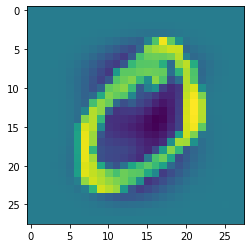

In [16]:
imshow(foreground_data[0])

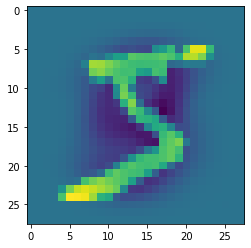

In [17]:
imshow(background_data[0])

In [18]:
def create_mosaic_img(bg_idx,fg_idx,fg): 
  """
  bg_idx : list of indexes of background_data[] to be used as background images in mosaic
  fg_idx : index of image to be used as foreground image from foreground data
  fg : at what position/index foreground image has to be stored out of 0-8
  """
  image_list=[]
  j=0
  for i in range(9):
    if i != fg:
      image_list.append(background_data[bg_idx[j]])
      j+=1
    else: 
      image_list.append(foreground_data[fg_idx])
      label = foreground_label[fg_idx] - fg1  # minus fg1 because our fore ground classes are fg1,fg2,fg3 but we have to store it as 0,1,2
  #image_list = np.concatenate(image_list ,axis=0)
  image_list = torch.stack(image_list) 
  return image_list,label

In [19]:
# def create_mosaic_img(bg_idx,fg_idx,fg): 
#   """
#   bg_idx : list of indexes of background_data[] to be used as background images in mosaic
#   fg_idx : index of image to be used as foreground image from foreground data
#   fg : at what position/index foreground image has to be stored out of 0-8
#   """
#   image_list=[]
#   j=0
#   for i in range(9):
#     if i != fg:
#       image_list.append(background_data[bg_idx[j]].type("torch.DoubleTensor"))
#       j+=1
#     else: 
#       image_list.append(foreground_data[fg_idx].type("torch.DoubleTensor"))
#       label = foreground_label[fg_idx]- fg1  # minus 7 because our fore ground classes are 7,8,9 but we have to store it as 0,1,2
#   #image_list = np.concatenate(image_list ,axis=0)
#   image_list = torch.stack(image_list) 
#   return image_list,label

In [20]:
desired_num = 40000
mosaic_list_of_images =[]      # list of mosaic images, each mosaic image is saved as list of 9 images
fore_idx =[]                   # list of indexes at which foreground image is present in a mosaic image i.e from 0 to 9               
mosaic_label=[]                # label of mosaic image = foreground class present in that mosaic
list_set_labels = [] 
for i in range(desired_num):
  set_idx = set()
  np.random.seed(i)
  bg_idx = np.random.randint(0,47335,8)
  set_idx = set(background_label[bg_idx].tolist())
  fg_idx = np.random.randint(0,12665)
  set_idx.add(foreground_label[fg_idx].item())
  fg = np.random.randint(0,9)
  fore_idx.append(fg)
  image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
  mosaic_list_of_images.append(image_list)
  mosaic_label.append(label)
  list_set_labels.append(set_idx)

In [21]:
mosaic_list_of_images_train = torch.stack(mosaic_list_of_images)
mosaic_list_of_images_train.shape

torch.Size([40000, 9, 1, 28, 28])

In [22]:
mean_train = torch.mean(mosaic_list_of_images_train[0:30000], dim=0, keepdims= True)
# std_train, _ = torch.max(mosaic_list_of_images_train[0:30000], dim=0, keepdims= True) 

mosaic_list_of_images_train = (mosaic_list_of_images_train - mean_train) # / torch.abs(std_train)

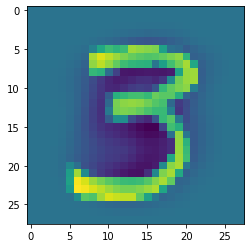

In [23]:
imshow(mosaic_list_of_images_train[0][2])

In [24]:
torch.sum(torch.isnan(mosaic_list_of_images_train))

tensor(0)

In [25]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list_of_images, mosaic_label, fore_idx):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list_of_images
    self.label = mosaic_label
    self.fore_idx = fore_idx

  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx], self.fore_idx[idx]

batch = 250
msd = MosaicDataset(mosaic_list_of_images_train[0:30000], mosaic_label[0:30000] , fore_idx[0:30000])
train_loader = DataLoader( msd,batch_size= batch ,shuffle=True)

test_data = MosaicDataset(mosaic_list_of_images_train[30000:40000], mosaic_label[30000:40000] , fore_idx[30000 : 40000])
test_loader = DataLoader( test_data,batch_size= batch ,shuffle=False)

In [26]:
class Focus(nn.Module):
  def __init__(self):
    super(Focus, self).__init__()

    self.fc1 = nn.Linear(28*28, 64, bias=False)
    torch.nn.init.xavier_normal_(self.fc1.weight)
    self.fc2 = nn.Linear(64, 1, bias=False)
    torch.nn.init.xavier_normal_(self.fc2.weight)

  def forward(self,z):  #y is avg image #z batch of list of 9 images
    y = torch.zeros([batch,1, 28,28], dtype=torch.float64)
    x = torch.zeros([batch,9],dtype=torch.float64)
    y = y.to("cuda")
    x = x.to("cuda")
    
    for i in range(9):
      # print(z[:,i].shape)
      # print(self.helper(z[:,i])[:,0].shape)
      x[:,i] = self.helper(z[:,i])[:,0]

    # print(x)
    x = F.softmax(x,dim=1)

    x1 = x[:,0]
    torch.mul(x1[:,None,None,None],z[:,0])

    for i in range(9):            
      x1 = x[:,i]          
      y = y + torch.mul(x1[:,None,None,None],z[:,i])

    return x, y
    
  def helper(self, x):
    x = x.view(-1, 28*28)
    x = F.relu(self.fc1(x))
    x = (self.fc2(x))

    return x

In [27]:
class Classification(nn.Module):
  def __init__(self):
    super(Classification, self).__init__()
    self.fc1 = nn.Linear(28*28, 2)
    torch.nn.init.xavier_normal_(self.fc1.weight)
    torch.nn.init.zeros_(self.fc1.bias)


  def forward(self, x):
    x = x.view(-1, 28*28)
    x = self.fc1(x)
    return x

In [28]:
torch.manual_seed(12)
focus_net = Focus().double()
focus_net = focus_net.to("cuda")

In [29]:
focus_net.fc1.weight.shape,focus_net.fc2.weight.shape

(torch.Size([64, 784]), torch.Size([1, 64]))

In [30]:
focus_net.fc1.weight.data[32:,:] = focus_net.fc1.weight.data[:32,:] #torch.nn.Parameter(torch.tensor([last_layer]) )
focus_net.fc1.weight[:32,:], focus_net.fc1.weight[32:,:] 

(tensor([[-0.0054,  0.0424,  0.0075,  ...,  0.0025,  0.0377,  0.0514],
         [ 0.0491, -0.0669,  0.0730,  ..., -0.0051,  0.0656, -0.0186],
         [ 0.0173, -0.0428, -0.0258,  ...,  0.0169, -0.0179,  0.0314],
         ...,
         [-0.0068,  0.0271, -0.0649,  ..., -0.0036, -0.0549, -0.0134],
         [-0.0167,  0.0215, -0.0455,  ...,  0.0468,  0.0390, -0.0636],
         [ 0.0279,  0.0397,  0.0168,  ...,  0.0309, -0.1029,  0.0739]],
        device='cuda:0', dtype=torch.float64, grad_fn=<SliceBackward>),
 tensor([[-0.0054,  0.0424,  0.0075,  ...,  0.0025,  0.0377,  0.0514],
         [ 0.0491, -0.0669,  0.0730,  ..., -0.0051,  0.0656, -0.0186],
         [ 0.0173, -0.0428, -0.0258,  ...,  0.0169, -0.0179,  0.0314],
         ...,
         [-0.0068,  0.0271, -0.0649,  ..., -0.0036, -0.0549, -0.0134],
         [-0.0167,  0.0215, -0.0455,  ...,  0.0468,  0.0390, -0.0636],
         [ 0.0279,  0.0397,  0.0168,  ...,  0.0309, -0.1029,  0.0739]],
        device='cuda:0', dtype=torch.float64, 

In [31]:
focus_net.fc2.weight.data[:,32:] = -focus_net.fc2.weight.data[:,:32] #torch.nn.Parameter(torch.tensor([last_layer]) )
focus_net.fc2.weight

Parameter containing:
tensor([[ 0.2891, -0.0671, -0.0405, -0.0219,  0.0982,  0.0840,  0.3137, -0.3567,
         -0.2656, -0.0298,  0.3952, -0.2473, -0.0650,  0.0675,  0.2740, -0.0417,
          0.1542,  0.1715,  0.1192,  0.0061, -0.1575, -0.3461,  0.1290, -0.0487,
          0.1300, -0.1493, -0.1454,  0.1714,  0.2288,  0.1587, -0.2628,  0.0639,
         -0.2891,  0.0671,  0.0405,  0.0219, -0.0982, -0.0840, -0.3137,  0.3567,
          0.2656,  0.0298, -0.3952,  0.2473,  0.0650, -0.0675, -0.2740,  0.0417,
         -0.1542, -0.1715, -0.1192, -0.0061,  0.1575,  0.3461, -0.1290,  0.0487,
         -0.1300,  0.1493,  0.1454, -0.1714, -0.2288, -0.1587,  0.2628, -0.0639]],
       device='cuda:0', dtype=torch.float64, requires_grad=True)

In [32]:
focus_net = focus_net.double().to("cuda")

In [33]:
focus_net.helper( torch.randn((10,1,28,28)).double().to("cuda") )

tensor([[ 1.6845e-17],
        [ 6.3071e-18],
        [ 4.1838e-17],
        [-5.7541e-17],
        [-1.1256e-16],
        [ 7.9768e-19],
        [-1.7032e-16],
        [-9.9691e-17],
        [-6.3137e-17],
        [-5.3446e-17]], device='cuda:0', dtype=torch.float64,
       grad_fn=<MmBackward>)

In [34]:
torch.manual_seed(12)
classify = Classification().double()
classify = classify.to("cuda")

In [35]:
classify.fc1.weight

Parameter containing:
tensor([[ 0.0760, -0.0803,  0.0810,  ..., -0.0120,  0.0564,  0.0058],
        [-0.0074, -0.0385, -0.0971,  ..., -0.0787,  0.0142,  0.0008]],
       device='cuda:0', dtype=torch.float64, requires_grad=True)

In [36]:
classify.fc1.bias

Parameter containing:
tensor([0., 0.], device='cuda:0', dtype=torch.float64, requires_grad=True)

In [37]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer_classify = optim.Adam(classify.parameters(), lr=0.01  ) #, momentum=0.9)
optimizer_focus = optim.Adam(focus_net.parameters(), lr=0.01  ) #, momentum=0.9)

In [38]:
col1=[]
col2=[]
col3=[]
col4=[]
col5=[]
col6=[]
col7=[]
col8=[]
col9=[]
col10=[]
col11=[]
col12=[]
col13=[]

In [39]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

with torch.no_grad():
  for data in train_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
    alphas, avg_images = focus_net(inputs)
    # print(alphas)
    outputs = classify(avg_images)

    _, predicted = torch.max(outputs.data, 1)

    for j in range(labels.size(0)):
      count += 1
      focus = torch.argmax(alphas[j])
      if alphas[j][focus] >= 0.5 :
        argmax_more_than_half += 1
      else:
        argmax_less_than_half += 1

      if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true += 1
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false += 1
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false += 1

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 30000 train images: %d %%' % ( 100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true %d =============> FTPT : %d %%" % (focus_true_pred_true , (100 * focus_true_pred_true / total) ) )
print("focus_false_pred_true %d =============> FFPT : %d %%" % (focus_false_pred_true, (100 * focus_false_pred_true / total) ) )
print("focus_true_pred_false %d =============> FTPF : %d %%" %( focus_true_pred_false , ( 100 * focus_true_pred_false / total) ) )
print("focus_false_pred_false %d =============> FFPF : %d %%" % (focus_false_pred_false, ( 100 * focus_false_pred_false / total) ) )

print("argmax_more_than_half ==================> ",argmax_more_than_half)
print("argmax_less_than_half ==================> ",argmax_less_than_half)
print(count)

print("="*100)

col1.append(0)
col2.append(argmax_more_than_half)
col3.append(argmax_less_than_half)
col4.append(focus_true_pred_true)
col5.append(focus_false_pred_true)
col6.append(focus_true_pred_false)
col7.append(focus_false_pred_false)

Accuracy of the network on the 30000 train images: 42 %
total correct 12758
total train set images 30000
focus_true_pred_true 1462 =============> FTPT : 4 %
focus_false_pred_true 11296 =============> FFPT : 37 %
focus_true_pred_false 1960 =============> FTPF : 6 %
focus_false_pred_false 15282 =============> FFPF : 50 %
argmax_more_than_half ==================>  0
argmax_less_than_half ==================>  30000
30000


In [40]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

with torch.no_grad():
  for data in test_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)

    _, predicted = torch.max(outputs.data, 1)

    for j in range(labels.size(0)):
      focus = torch.argmax(alphas[j])
      if alphas[j][focus] >= 0.5 :
        argmax_more_than_half += 1
      else:
        argmax_less_than_half += 1

      if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true += 1
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false += 1
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false += 1

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true %d =============> FTPT : %d %%" % (focus_true_pred_true , (100 * focus_true_pred_true / total) ) )
print("focus_false_pred_true %d =============> FFPT : %d %%" % (focus_false_pred_true, (100 * focus_false_pred_true / total) ) )
print("focus_true_pred_false %d =============> FTPF : %d %%" %( focus_true_pred_false , ( 100 * focus_true_pred_false / total) ) )
print("focus_false_pred_false %d =============> FFPF : %d %%" % (focus_false_pred_false, ( 100 * focus_false_pred_false / total) ) )

print("argmax_more_than_half ==================> ",argmax_more_than_half)
print("argmax_less_than_half ==================> ",argmax_less_than_half)
col8.append(argmax_more_than_half)
col9.append(argmax_less_than_half)
col10.append(focus_true_pred_true)
col11.append(focus_false_pred_true)
col12.append(focus_true_pred_false)
col13.append(focus_false_pred_false)

Accuracy of the network on the 10000 test images: 42 %
total correct 4213
total train set images 10000
focus_true_pred_true 479 =============> FTPT : 4 %
focus_false_pred_true 3734 =============> FFPT : 37 %
focus_true_pred_false 640 =============> FTPF : 6 %
focus_false_pred_false 5147 =============> FFPF : 51 %
argmax_more_than_half ==================>  0
argmax_less_than_half ==================>  10000


In [41]:
nos_epochs = 1000
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0


for epoch in range(nos_epochs):  # loop over the dataset multiple times

  focus_true_pred_true =0
  focus_false_pred_true =0
  focus_true_pred_false =0
  focus_false_pred_false =0
  
  argmax_more_than_half = 0
  argmax_less_than_half =0
  
  running_loss = 0.0
  epoch_loss = []
  cnt=0

  iteration = desired_num // batch
  
  #training data set
  
  for i, data in  enumerate(train_loader):
    inputs , labels , fore_idx = data
    inputs, labels = inputs.to("cuda"), labels.to("cuda")
    inputs = inputs.double()
    # zero the parameter gradients
    
    optimizer_focus.zero_grad()
    optimizer_classify.zero_grad()
    
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)

    _, predicted = torch.max(outputs.data, 1)
#     print(outputs)
#     print(outputs.shape,labels.shape , torch.argmax(outputs, dim=1))

    loss = criterion(outputs, labels) 
    loss.backward()
    optimizer_focus.step()
    optimizer_classify.step()

    running_loss += loss.item()
    mini = 60
    if cnt % mini == mini-1:    # print every 40 mini-batches
      print('[%d, %5d] loss: %.3f' %(epoch + 1, cnt + 1, running_loss / mini))
      epoch_loss.append(running_loss/mini)
      running_loss = 0.0
    cnt=cnt+1
    
    if epoch % 5 == 0:
      for j in range (batch):
        focus = torch.argmax(alphas[j])

        if(alphas[j][focus] >= 0.5):
          argmax_more_than_half +=1
        else:
          argmax_less_than_half +=1

        if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1

        elif(focus != fore_idx[j] and predicted[j] == labels[j]):
          focus_false_pred_true +=1

        elif(focus == fore_idx[j] and predicted[j] != labels[j]):
          focus_true_pred_false +=1

        elif(focus != fore_idx[j] and predicted[j] != labels[j]):
          focus_false_pred_false +=1

  if(np.mean(epoch_loss) <= 0.009):
      break;

  if epoch % 5 == 0:
    col1.append(epoch + 1)
    col2.append(argmax_more_than_half)
    col3.append(argmax_less_than_half)
    col4.append(focus_true_pred_true)
    col5.append(focus_false_pred_true)
    col6.append(focus_true_pred_false)
    col7.append(focus_false_pred_false)
    print("="*20)
    print("Train FTPT : ", col4)
    print("Train FFPT : ", col5)
    #************************************************************************
    #testing data set  
    # focus_net.eval()
    with torch.no_grad():
      focus_true_pred_true =0
      focus_false_pred_true =0
      focus_true_pred_false =0
      focus_false_pred_false =0

      argmax_more_than_half = 0
      argmax_less_than_half =0
      for data in test_loader:
        inputs, labels , fore_idx = data
        inputs = inputs.double()
        inputs, labels = inputs.to("cuda"), labels.to("cuda")
        alphas, avg_images = focus_net(inputs)
        outputs = classify(avg_images)
        _, predicted = torch.max(outputs.data, 1)

        for j in range (batch):
          focus = torch.argmax(alphas[j])

          if(alphas[j][focus] >= 0.5):
            argmax_more_than_half +=1
          else:
            argmax_less_than_half +=1

          if(focus == fore_idx[j] and predicted[j] == labels[j]):
            focus_true_pred_true += 1

          elif(focus != fore_idx[j] and predicted[j] == labels[j]):
            focus_false_pred_true +=1

          elif(focus == fore_idx[j] and predicted[j] != labels[j]):
            focus_true_pred_false +=1

          elif(focus != fore_idx[j] and predicted[j] != labels[j]):
            focus_false_pred_false +=1
      
    col8.append(argmax_more_than_half)
    col9.append(argmax_less_than_half)
    col10.append(focus_true_pred_true)
    col11.append(focus_false_pred_true)
    col12.append(focus_true_pred_false)
    col13.append(focus_false_pred_false)
    print("Test FTPT : ", col10)
    print("Test FFPT : ", col11)
    print("="*20)
    
print('Finished Training')

[1,    60] loss: 0.221
[1,   120] loss: 0.050
Train FTPT :  [1462, 25675]
Train FFPT :  [11296, 2604]
Test FTPT :  [479, 9678]
Test FFPT :  [3734, 158]
[2,    60] loss: 0.032
[2,   120] loss: 0.023
[3,    60] loss: 0.015
[3,   120] loss: 0.022
[4,    60] loss: 0.024
[4,   120] loss: 0.015
[5,    60] loss: 0.014
[5,   120] loss: 0.012
[6,    60] loss: 0.018
[6,   120] loss: 0.020
Train FTPT :  [1462, 25675, 29614]
Train FFPT :  [11296, 2604, 250]
Test FTPT :  [479, 9678, 9886]
Test FFPT :  [3734, 158, 74]
[7,    60] loss: 0.018
[7,   120] loss: 0.020
[8,    60] loss: 0.021
[8,   120] loss: 0.016
[9,    60] loss: 0.017
[9,   120] loss: 0.013
[10,    60] loss: 0.023
[10,   120] loss: 0.033
[11,    60] loss: 0.029
[11,   120] loss: 0.017
Train FTPT :  [1462, 25675, 29614, 29676]
Train FFPT :  [11296, 2604, 250, 216]
Test FTPT :  [479, 9678, 9886, 9839]
Test FFPT :  [3734, 158, 74, 101]
[12,    60] loss: 0.028
[12,   120] loss: 0.029
[13,    60] loss: 0.016
[13,   120] loss: 0.035
[14,    6

In [42]:
df_train = pd.DataFrame()
df_test = pd.DataFrame()

In [43]:
columns = ["epochs", "argmax > 0.5" ,"argmax < 0.5", "focus_true_pred_true", "focus_false_pred_true", "focus_true_pred_false", "focus_false_pred_false" ]

In [44]:
df_train[columns[0]] = col1
df_train[columns[1]] = col2
df_train[columns[2]] = col3
df_train[columns[3]] = col4
df_train[columns[4]] = col5
df_train[columns[5]] = col6
df_train[columns[6]] = col7

df_test[columns[0]] = col1
df_test[columns[1]] = col8
df_test[columns[2]] = col9
df_test[columns[3]] = col10
df_test[columns[4]] = col11
df_test[columns[5]] = col12
df_test[columns[6]] = col13

In [45]:
df_train

,epochs,argmax > 0.5,argmax < 0.5,focus_true_pred_true,focus_false_pred_true,focus_true_pred_false,focus_false_pred_false
0,0,0,30000,1462,11296,1960,15282
1,1,28441,1559,25675,2604,138,1583
2,6,29977,23,29614,250,22,114
3,11,29999,1,29676,216,18,90
4,16,30000,0,29738,166,21,75
5,21,29999,1,29636,229,21,114
6,26,30000,0,29747,169,10,74


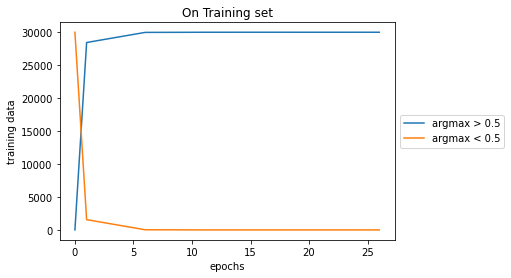

In [46]:
# plt.figure(12,12)
plt.plot(col1,col2, label='argmax > 0.5')
plt.plot(col1,col3, label='argmax < 0.5')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("training data")
plt.title("On Training set")
plt.show()



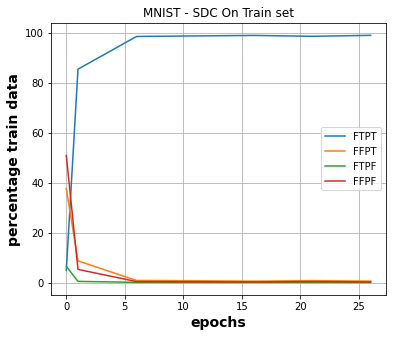

In [47]:
plt.figure(figsize=(6,5))
plt.plot(col1,np.array(col4)/300, label ="FTPT")
plt.plot(col1,np.array(col5)/300, label ="FFPT")
plt.plot(col1,np.array(col6)/300, label ="FTPF")
plt.plot(col1,np.array(col7)/300, label ="FFPF")
plt.title("MNIST - SDC On Train set")
plt.grid()
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend()
plt.xlabel("epochs", fontsize=14, fontweight = 'bold')
plt.ylabel("percentage train data", fontsize=14, fontweight = 'bold')
plt.savefig(path+"mnist_train.png", bbox_inches="tight")
plt.savefig(path+"mnist_train.pdf", bbox_inches="tight")
plt.savefig("mnist_train.png", bbox_inches="tight")
plt.savefig("mnist_train.pdf", bbox_inches="tight")
plt.show()

In [48]:
df_test

,epochs,argmax > 0.5,argmax < 0.5,focus_true_pred_true,focus_false_pred_true,focus_true_pred_false,focus_false_pred_false
0,0,0,10000,479,3734,640,5147
1,1,9921,79,9678,158,21,143
2,6,9998,2,9886,74,10,30
3,11,9999,1,9839,101,2,58
4,16,10000,0,9896,52,7,45
5,21,10000,0,9885,56,6,53
6,26,10000,0,9902,51,5,42


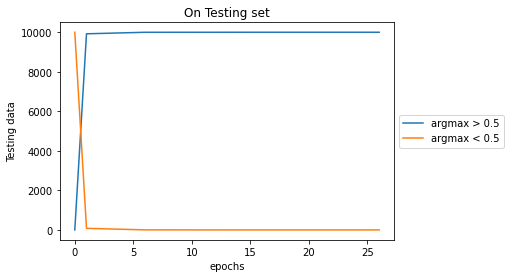

In [49]:
# plt.figure(12,12)
plt.plot(col1,col8, label='argmax > 0.5')
plt.plot(col1,col9, label='argmax < 0.5')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("Testing data")
plt.title("On Testing set")
plt.show()



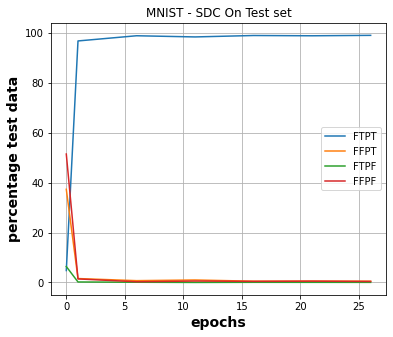

In [50]:
plt.figure(figsize=(6,5))
plt.plot(col1,np.array(col10)/100, label ="FTPT")
plt.plot(col1,np.array(col11)/100, label ="FFPT")
plt.plot(col1,np.array(col12)/100, label ="FTPF")
plt.plot(col1,np.array(col13)/100, label ="FFPF")
plt.title("MNIST - SDC On Test set")
plt.grid()
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend()
plt.xlabel("epochs", fontsize=14, fontweight = 'bold')
plt.ylabel("percentage test data", fontsize=14, fontweight = 'bold')
plt.savefig(path+"mnist_test.png", bbox_inches="tight")
plt.savefig(path+"mnist_test.pdf", bbox_inches="tight")
plt.savefig("mnist_test.png", bbox_inches="tight")
plt.savefig("mnist_test.pdf", bbox_inches="tight")
plt.show()

In [51]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

with torch.no_grad():
  for data in train_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)

    _, predicted = torch.max(outputs.data, 1)

    for j in range(labels.size(0)):
      focus = torch.argmax(alphas[j])
      if alphas[j][focus] >= 0.5 :
        argmax_more_than_half += 1
      else:
        argmax_less_than_half += 1

      if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true += 1
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false += 1
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false += 1

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 30000 train images: %d %%' % (
    100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true %d =============> FTPT : %d %%" % (focus_true_pred_true , (100 * focus_true_pred_true / total) ) )
print("focus_false_pred_true %d =============> FFPT : %d %%" % (focus_false_pred_true, (100 * focus_false_pred_true / total) ) )
print("focus_true_pred_false %d =============> FTPF : %d %%" %( focus_true_pred_false , ( 100 * focus_true_pred_false / total) ) )
print("focus_false_pred_false %d =============> FFPF : %d %%" % (focus_false_pred_false, ( 100 * focus_false_pred_false / total) ) )

print("argmax_more_than_half ==================> ",argmax_more_than_half)
print("argmax_less_than_half ==================> ",argmax_less_than_half)

Accuracy of the network on the 30000 train images: 99 %
total correct 29966
total train set images 30000
focus_true_pred_true 29823 =============> FTPT : 99 %
focus_false_pred_true 143 =============> FFPT : 0 %
focus_true_pred_false 2 =============> FTPF : 0 %
focus_false_pred_false 32 =============> FFPF : 0 %
argmax_more_than_half ==================>  30000
argmax_less_than_half ==================>  0


In [52]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

with torch.no_grad():
  for data in test_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)

    _, predicted = torch.max(outputs.data, 1)

    for j in range(labels.size(0)):
      focus = torch.argmax(alphas[j])
      if alphas[j][focus] >= 0.5 :
        argmax_more_than_half += 1
      else:
        argmax_less_than_half += 1

      if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true += 1
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false += 1
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false += 1

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true %d =============> FTPT : %d %%" % (focus_true_pred_true , (100 * focus_true_pred_true / total) ) )
print("focus_false_pred_true %d =============> FFPT : %d %%" % (focus_false_pred_true, (100 * focus_false_pred_true / total) ) )
print("focus_true_pred_false %d =============> FTPF : %d %%" %( focus_true_pred_false , ( 100 * focus_true_pred_false / total) ) )
print("focus_false_pred_false %d =============> FFPF : %d %%" % (focus_false_pred_false, ( 100 * focus_false_pred_false / total) ) )

print("argmax_more_than_half ==================> ",argmax_more_than_half)
print("argmax_less_than_half ==================> ",argmax_less_than_half)

Accuracy of the network on the 10000 test images: 99 %
total correct 9967
total train set images 10000
focus_true_pred_true 9920 =============> FTPT : 99 %
focus_false_pred_true 47 =============> FFPT : 0 %
focus_true_pred_false 2 =============> FTPF : 0 %
focus_false_pred_false 31 =============> FFPF : 0 %
argmax_more_than_half ==================>  10000
argmax_less_than_half ==================>  0


In [53]:
correct = 0
total = 0

with torch.no_grad():
  for data in train_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels = inputs.to("cuda"), labels.to("cuda")
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)

    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 30000 train images: %d %%' % ( 100 * correct / total))
print("total correct", correct)
print("total train set images", total)

Accuracy of the network on the 30000 train images: 99 %
total correct 29966
total train set images 30000


In [54]:
correct = 0
total = 0

with torch.no_grad():
  for data in test_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels = inputs.to("cuda"), labels.to("cuda")
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)

    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % ( 100 * correct / total))
print("total correct", correct)
print("total train set images", total)

Accuracy of the network on the 10000 test images: 99 %
total correct 9967
total train set images 10000
